In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import pandas as pd
import pickle
from collections import Counter
import matplotlib.pyplot as plt 
from scipy.stats import pearsonr

from constants_and_utils import *

plot_dir = "./result/plot"

/tmp/ipykernel_1591584/326488921.py:23: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


# Data Exploration

In [4]:
# Get Data
df = pd.read_csv("./datav0/observed_transactions.psv", sep="|")
print(f"Synthetica data with shape {df.shape}, lets peek ...")
df["origin_company"] = df["origin_company"].str.replace('company','').astype(int)
df["dest_company"] = df["dest_company"].str.replace('company','')
df["dest_company"] = df["dest_company"].str.replace('market','20') # We denote market as 20
df["dest_company"] = df["dest_company"].astype(int)
df["product"] = df["product"].str.replace('product','').astype(int)
df.head()

Synthetica data with shape (74887, 5), lets peek ...


,time,amt,origin_company,dest_company,product
0,1,15.801313,3,9,62
1,2,37.329604,3,5,61
2,3,18.087301,3,9,62
3,3,62.191280,16,5,56
4,3,640.205554,16,3,56


In [17]:
df.describe()

,ts,weight,source,target,product
count,74887.000000,74887.000000,74887.000000,74887.000000,74887.000000
mean,75.248494,399.983197,9.095891,10.617784,47.026627
std,42.492094,560.856785,6.134606,6.845420,28.929197
min,1.000000,0.000014,0.000000,0.000000,0.000000
25%,38.000000,92.217437,3.000000,3.000000,23.000000
50%,75.000000,204.619267,9.000000,11.000000,40.000000
75%,112.000000,513.697861,16.000000,17.000000,75.000000
max,149.000000,5781.804779,19.000000,20.000000,99.000000


origin_company has max_count 10492 and min_count 748
dest_company has max_count 10314 and min_count 897
product has max_count 3453 and min_count 149


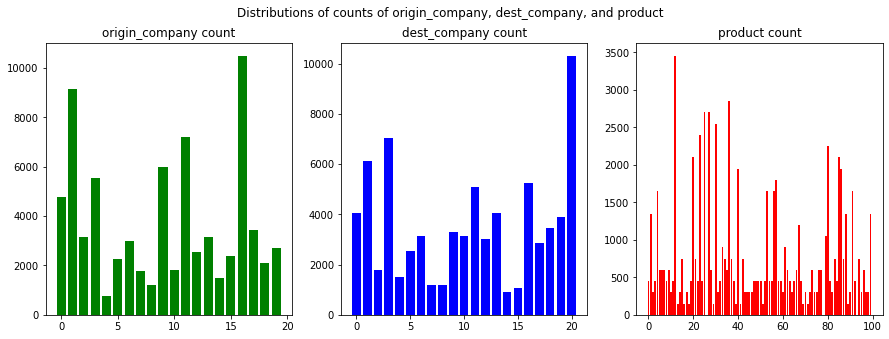

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Distributions of counts of origin_company, dest_company, and product')

counter_src = Counter(df['origin_company'])
axs[0].bar(counter_src.keys(), counter_src.values(), color='g')
axs[0].set_title(f"origin_company count")
print(f"origin_company has max_count {max(counter_src.values())} and min_count {min(counter_src.values())}")


counter_dst = Counter(df['dest_company'])
axs[1].bar(counter_dst.keys(), counter_dst.values(), color='b')
axs[1].set_title(f"dest_company count")
print(f"dest_company has max_count {max(counter_dst.values())} and min_count {min(counter_dst.values())}")

counter_prod = Counter(df['product'])
axs[2].bar(counter_prod.keys(), counter_prod.values(), color='r')
axs[2].set_title(f"product count")
print(f"product has max_count {max(counter_prod.values())} and min_count {min(counter_prod.values())}")

In [7]:
# rename column names for later use
df = df.rename(columns={"origin_company": "source", "dest_company": "target", "time": "ts", "amt": "weight"})
df.head()

,ts,weight,source,target,product
0,1,15.801313,3,9,62
1,2,37.329604,3,5,61
2,3,18.087301,3,9,62
3,3,62.191280,16,5,56
4,3,640.205554,16,3,56


# Analysis

## Prepare Data

In [8]:
# Identify products
SUPPLY_PROD, BUY_PROD = 3, 9 # Buy --> company --> supply
print(f"One buys product {BUY_PROD} to supply product {SUPPLY_PROD}")

def identify_companies(SUPPLY_PROD, BUY_PROD):
    assert 0<=SUPPLY_PROD and SUPPLY_PROD<=99
    assert 0<=BUY_PROD and BUY_PROD<=99
    
    # Compute product specific supply, buy dataframe
    supply_df = df[(df['product']==SUPPLY_PROD)]
    buy_df = df[(df['product']==BUY_PROD)]
    
    # Identify company: top SUPPLY_PROD supplier AND BUY_PROD buyer
    supply_index = supply_df.groupby("source", as_index=False).sum()
    buy_index = buy_df.groupby("target", as_index=False).sum()
    index = pd.merge(supply_index, buy_index, how='inner', left_on="source", right_on="target")
    
    assert (index['source_x']==index['target_y']).all()
    COMPANIES = index['source_x'].values
    # print(f"COMPANIES involved are {COMPANIES}")
    return COMPANIES
COMPANIES = identify_companies(SUPPLY_PROD, BUY_PROD)

One buys product 9 to supply product 3


In [9]:
def get_df_for_company(SUPPLY_PROD, BUY_PROD, COMPANY):
    # Compute product specific supply, buy dataframe
    supply_df = df[(df['product']==SUPPLY_PROD) & (df['source']==COMPANY)]
    buy_df = df[(df['product']==BUY_PROD) & (df['target']==COMPANY)]
    # print(f"supply shape {supply_df.shape}, buy shape {buy_df.shape}")
    return supply_df, buy_df
COMPANY = COMPANIES[0]
supply_df, buy_df = get_df_for_company(SUPPLY_PROD, BUY_PROD, COMPANY)

## Time Series

In [10]:
# Get supply_summary, buy_summary
def get_summary_df(supply_df, buy_df, time='ts'): # Use given timestamp as basic unit
    supply_summary = supply_df.groupby(time)['weight'].sum()
    buy_summary = buy_df.groupby(time)['weight'].sum()
    return supply_summary, buy_summary

# Plot weights
def plot_weights(supply_summary, buy_summary):
    print("Plotting purchases and sales of products without lag")
    fig, axes = plt.subplots(2, 1, figsize=(8, 7), sharex=True)
    ax = axes[0]
    ax.set_title(f'Purchases of buy product {BUY_PROD}', fontsize=12)
    ax.plot(buy_summary.index.values, buy_summary.values)
    ax.set_ylabel('Total weight', fontsize=12)
    ax = axes[1]           
    ax.set_title(f'Sales of supply product {SUPPLY_PROD}', fontsize=12)
    ax.plot(supply_summary.index.values, supply_summary.values)
    ax.set_ylabel('Total weight', fontsize=12)
    ax.set_xlabel('Timestamp')
    plt.show()
    
    # save plot
    if not os.path.exists(plot_dir):
        os.mkdir(plot_dir)
    fig.savefig(f"{plot_dir}/B{BUY_PROD}_S{SUPPLY_PROD}_C{COMPANY}.jpg", bbox_inches="tight")

def compute_correlations(supply_summary, buy_summary, num_before=0, num_after=0, lag=0):
    # Add lags
    if lag!=0:
        buy_summary.index += lag
        
    # Apply smoothing
    smooth_values = apply_smoothing(supply_summary.values, num_before=num_before, num_after=num_after)
    assert(len(supply_summary)==len(smooth_values))
    supply_summary.replace(supply_summary.values, smooth_values, inplace=True)
    supply_summary.fillna(0, inplace=True)
    
    smooth_values = apply_smoothing(buy_summary.values, num_before=num_before, num_after=num_after)
    assert(len(buy_summary)==len(smooth_values))
    buy_summary.replace(buy_summary.values, smooth_values, inplace=True)
    buy_summary.fillna(0, inplace=True)
    
    # Calculate correlation
    merged = pd.merge(supply_summary.rename('x'), buy_summary.rename('y'), left_index=True, right_index=True, how='inner')
    if len(merged.x) < 2 or len(merged.y) < 2:
        r, p = float("nan"), float("nan")
    else:
        r, p = pearsonr(merged.x, merged.y)
    # print('r=%.3f (n=%d, p=%.3f)' % (r, len(merged), p)) # n is number of ts
    return (r, len(merged), p)

Plotting purchases and sales of products without lag


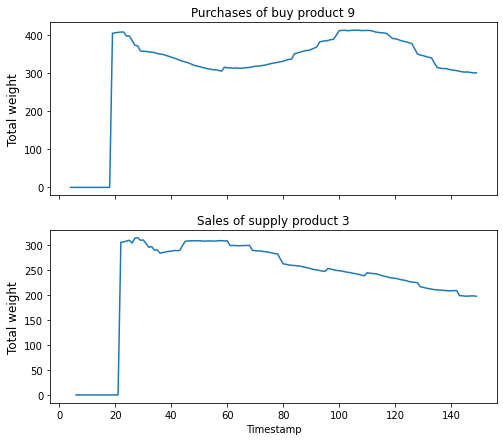

rnp is (0.7291044479354173, 130, 7.974059420598316e-23)


In [11]:
supply_summary, buy_summary = get_summary_df(supply_df, buy_df)
rnp = compute_correlations(supply_summary, buy_summary, num_before=15, num_after=15, lag=0)
plot_weights(supply_summary, buy_summary)
print(f"rnp is {rnp}")

## Mega Analysis
We loop through all $\textbf{BUY_PROD}$ in [0, 99], $\textbf{SUPPLY_PROD}$ in [0, 99] to compute correlation score for all involved companies with smoothing parameters num_before=15, num_after = 15, and $\textbf{lag}$ in [0, 149]

In [12]:
MIN_PRODUCT, MAX_PRODUCT = min(df["product"]), max(df["product"])
print(f"MIN_PRODUCT {MIN_PRODUCT}, MAX_PRODUCT {MAX_PRODUCT}")
MIN_LAG, MAX_LAG = 0, max(df["ts"])
print(f"MIN_LAG {MIN_LAG}, MAX_LAG {MAX_LAG}")

MIN_PRODUCT 0, MAX_PRODUCT 99
MIN_LAG 0, MAX_LAG 149


In [13]:
# Define functions
import threading
result_list = []
def function(BUY_PROD, SUPPLY_PROD, COMPANY):
    for lag in range(MIN_LAG, MAX_LAG+1):
        supply_df, buy_df = get_df_for_company(SUPPLY_PROD=SUPPLY_PROD, BUY_PROD=BUY_PROD, COMPANY=COMPANY)
        supply_summary, buy_summary = get_summary_df(supply_df, buy_df)
        (r, n, p) = compute_correlations(supply_summary, buy_summary, num_before=15, num_after=15, lag=lag)
        result_list.append({'BUY_PROD': BUY_PROD, 
                            'SUPPLY_PROD': SUPPLY_PROD, 
                            'COMPANY': COMPANY, 
                            'lag': lag, 
                            'r': r, 
                            'n': n, 
                            'p': p})  

In [14]:
# Time Estimation
import time
st = time.time()
function(3, 4, 3)
et = time.time()
print(f"Total time to run function() is {et - st} seconds")
threads = []

Total time is 3.4568159580230713 seconds


In [15]:
# Multithread Per Company Run
for COMPANY in range(20): # company 20 not included  
    threads = []
    st = time.time()
    SUPPLY_PRODUCT_LIST = list(set(df[(df["source"]==COMPANY)]["product"]))
    BUY_PRODUCT_LIST = list(set(df[(df["target"]==COMPANY)]["product"]))
    print(f"Company {COMPANY} sells products {SUPPLY_PRODUCT_LIST}")
    print(f"Company {COMPANY} buys products {BUY_PRODUCT_LIST}")
    for BUY_PROD in BUY_PRODUCT_LIST:
        for SUPPLY_PROD in SUPPLY_PRODUCT_LIST:
            if BUY_PROD==SUPPLY_PROD: continue
            t = threading.Thread(target=function, args=(BUY_PROD, SUPPLY_PROD, COMPANY,))
            threads.append(t)
    print(f"There are {len(threads)} threads to execute for company {COMPANY}")

    for t in threads: 
        t.start()
    for t in threads:
        t.join()
    
    et = time.time()
    print(f"Total time is {et - st} seconds for company {COMPANY}")
    
    # save results
    result_df = pd.DataFrame(result_list)
    result_df.to_csv(f'./result/result{COMPANY}.csv', index=False) 

Company 11 sells products [0, 5, 7, 13, 15, 23, 25, 32, 34, 35, 36, 44, 46, 54, 57, 68, 69, 70, 79, 82, 86, 87, 94]
Company 11 buys products [0, 1, 5, 12, 19, 20, 25, 27, 29, 36, 37, 40, 46, 56, 61, 63, 67, 72, 76, 77, 79, 80, 91, 98]
There are 546 threads to execute for company 11


/home/zhiyin/supplychain/supply-chains/synthetic_exp/constants_and_utils.py:93: RuntimeWarning: Mean of empty slice
  smoothed_ts[i] = np.nanmean(ts[i-num_before:i+num_after+1])
/home/zhiyin/supplychain/supply-chains/synthetic_exp/constants_and_utils.py:93: RuntimeWarning: Mean of empty slice
  smoothed_ts[i] = np.nanmean(ts[i-num_before:i+num_after+1])


Total time is 5780.168220996857 seconds for company 11


## Compare Against Ground-Truth Production Functions

In [18]:
import pandas as pd
import matplotlib.pyplot as plt 
import re

In [19]:
# Read in overall psv
df = pd.read_table(f'./datav0/production_fn.psv', sep= "|") 
print(f"Import production_fn.psv as df with shape {df.shape}")

# Filter out nonlinear relations
nonlinear_op_matches = ["ExoProd", "min", "^", "x", "/", "max"]
df["nonlinear_flag"] = [sum([op in value for op in nonlinear_op_matches])==0 for value in df["prod_func"]]
df = df[df["nonlinear_flag"]]

# Tease out company, supply_prod, list of buy_prod from strings for later use
company_lambda = lambda row: int(re.split('company|-product', row["product"])[1])
supply_prod_lambda = lambda row: int(re.split('company|-product', row["product"])[2])
buy_prod_list_lambda = lambda row: [int(p) for p in re.split('product|\)', row["prod_func"])[1::2]]

df["company"] = df.apply(company_lambda, axis=1)
df["supply_prod"] = df.apply(supply_prod_lambda, axis=1)
df["buy_prod_list"] = df.apply(buy_prod_list_lambda, axis=1)

print(f"After preprocessing, df has shape {df.shape}")
df.head()

Import production_fn.psv as df with shape (280, 2)
After preprocessing, df has shape (88, 6)


,product,prod_func,nonlinear_flag,company,supply_prod,buy_prod_list
0,company0-product93,0.391(company16-product56)+ 0.197(company17-pr...,True,0,93,"[56, 27, 40, 5, 88, 57, 85]"
1,company0-product89,0.734(company1-product23)+ 0.881(company16-pro...,True,0,89,"[23, 20, 12, 57, 85, 99]"
4,company0-product65,0.488(company0-product44)+ 0.279(company12-pro...,True,0,65,"[44, 59, 47]"
19,company0-product98,0.844(company9-product55)+ 0.609(company17-pro...,True,0,98,"[55, 33, 66]"
21,company0-product64,0.806(company0-product71)+ 0.274(company14-pro...,True,0,64,"[71, 11, 39, 68]"


In [39]:
# Plot
def subplot(ax, title, supply_prod, buy_prod_list):
    df = result_df[result_df["SUPPLY_PROD"] == supply_prod]
    df = df.loc[df.groupby(['BUY_PROD', 'SUPPLY_PROD'], sort=False).r.idxmax()]
    condition = df["BUY_PROD"].isin(buy_prod_list)

    x_values = df[condition]["BUY_PROD"]
    y_values = df[condition]["r"]

    x_baseline_values = df[~condition]["BUY_PROD"]
    y_baseline_values = df[~condition]["r"]
    
    info_dict = {} # maps buy product to what percent of baseline buy products it is greater than
    for x_val, y_val in zip(x_values, y_values):
        p = sum(y_val > y_val_baseline for y_val_baseline in y_baseline_values) / float(len(y_baseline_values))
        info_dict[x_val] = p
    
    ax.scatter(x_values, y_values, color='r', label="prod_func")
    ax.scatter(x_baseline_values, y_baseline_values, color='b', label="baseline")
    
    ax.set_title(f"{title}")
    ax.legend()
    return info_dict

def plot(result_df, prod_df, company):
    LENGTH, WIDTH = (prod_df.shape[0] + 3) // 4, 4
    
    # subplots
    fig, axes = plt.subplots(LENGTH, WIDTH, figsize = (WIDTH*4, LENGTH*4), sharex=True, sharey=True, squeeze=False)
    perc_, total_ = 0.0, 0.0
    for i, row in prod_df.iterrows():
        supply_prod = row["supply_prod"]
        buy_prod_list = row["buy_prod_list"]
        prod_func = f"p{buy_prod_list}->c{row.company}->p{supply_prod}"

        x, y = i%LENGTH, i//LENGTH
        info_dict = subplot(axes[x][y], prod_func, supply_prod, buy_prod_list)
        
        perc_ += sum(info_dict.values())
        total_ += len(info_dict)
    print(f"Average percentage is {perc_ / total_}\n")

    # set x, y labels
    fig.text(0.5, 0.04, 'Buy product index', ha='center') # xlabel
    fig.text(0.04, 0.5, 'Correlation of buy_prod-supply_prod amount', va='center', rotation='vertical') # ylabel
    
    fig.savefig(f'./result/plot/plot{company}.jpg')
    
    return perc_ / total_

Plot company 0: result shape (63000, 7) and linear production functions shape (9, 6)
Average percentage is 0.7224275362318842

Plot company 1: result shape (84900, 7) and linear production functions shape (6, 6)
Average percentage is 0.6818571697453686

Plot company 2: result shape (69450, 7) and linear production functions shape (6, 6)
Average percentage is 0.8599190283400809

Plot company 3: result shape (162900, 7) and linear production functions shape (6, 6)
Average percentage is 0.6777974260732881

Plot company 4: result shape (31500, 7) and linear production functions shape (3, 6)
Average percentage is 1.0

Plot company 5: result shape (17550, 7) and linear production functions shape (5, 6)
Average percentage is 0.7013257575757575

Plot company 6: result shape (47100, 7) and linear production functions shape (2, 6)
Average percentage is 0.7783333333333333

Plot company 7: result shape (51900, 7) and linear production functions shape (2, 6)
Average percentage is 0.8840579710144928

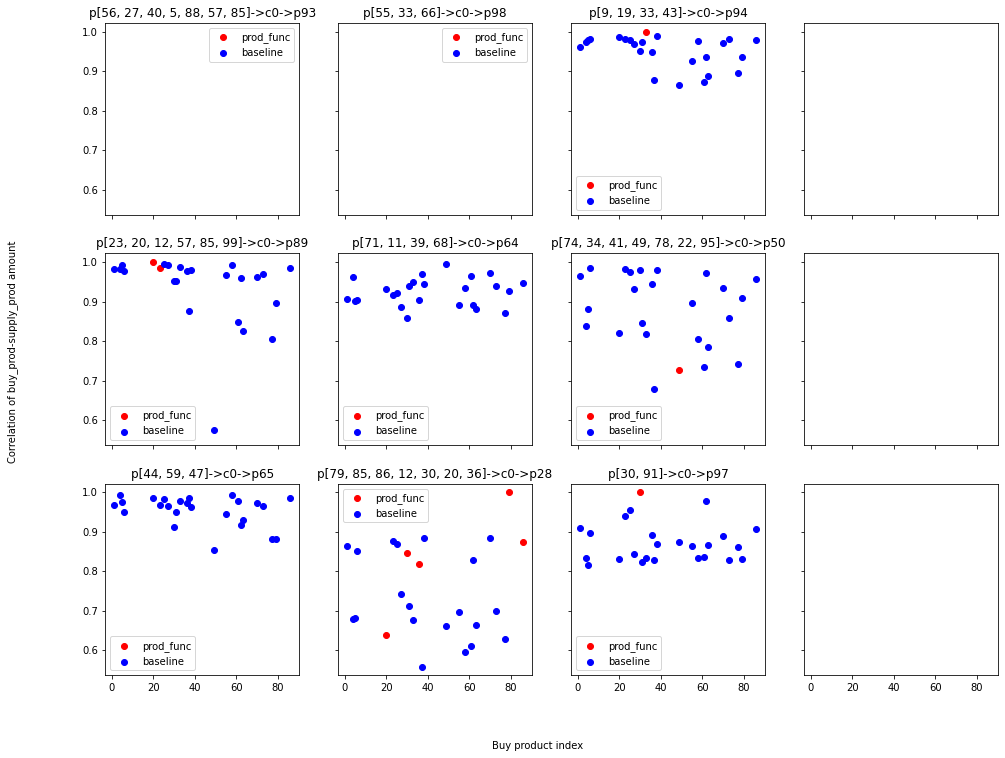

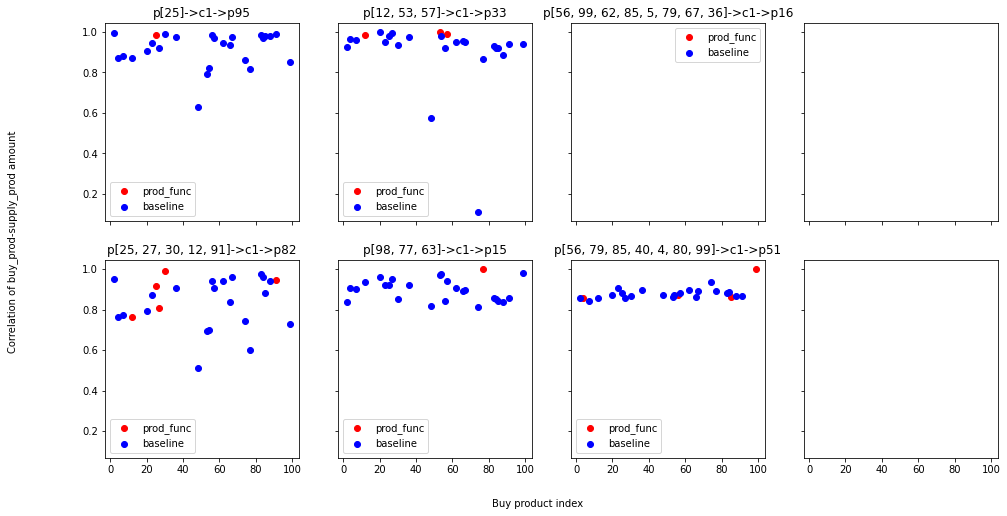

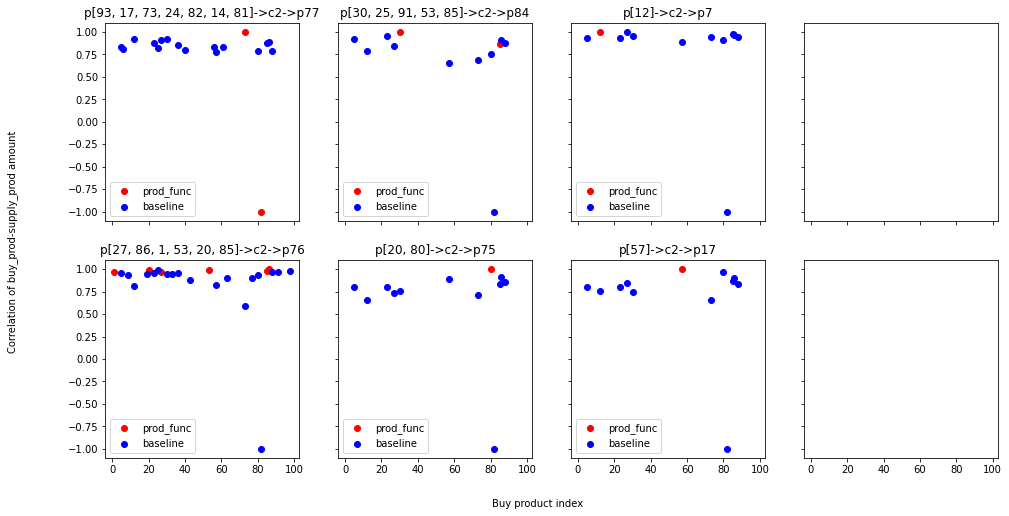

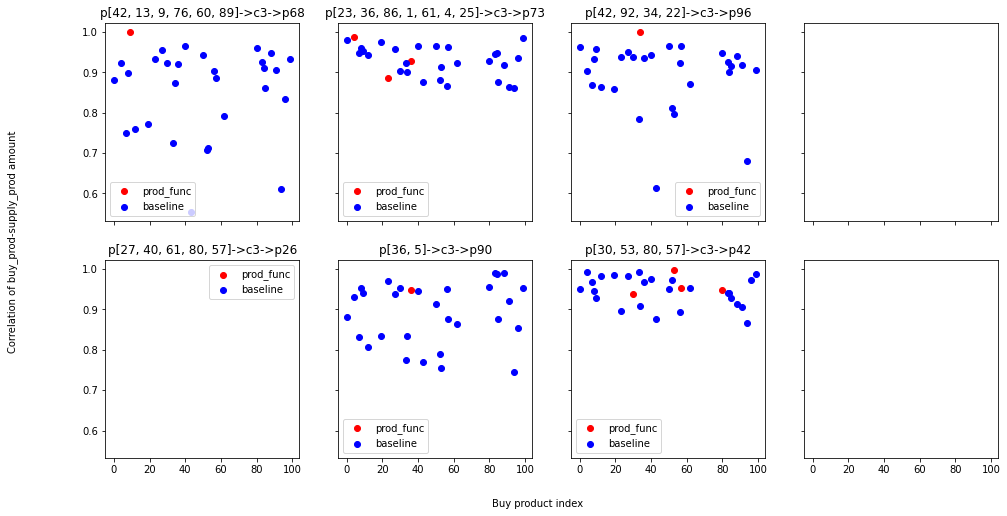

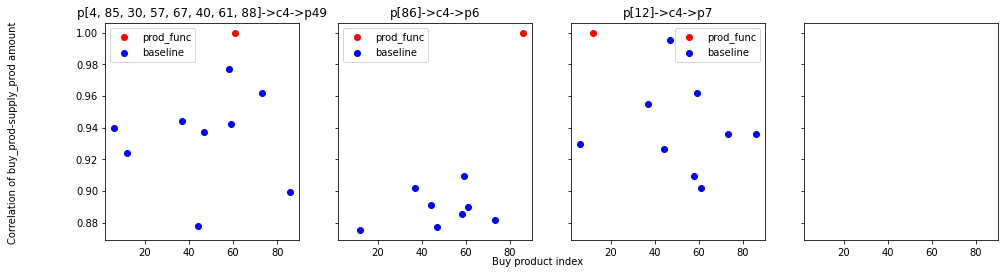

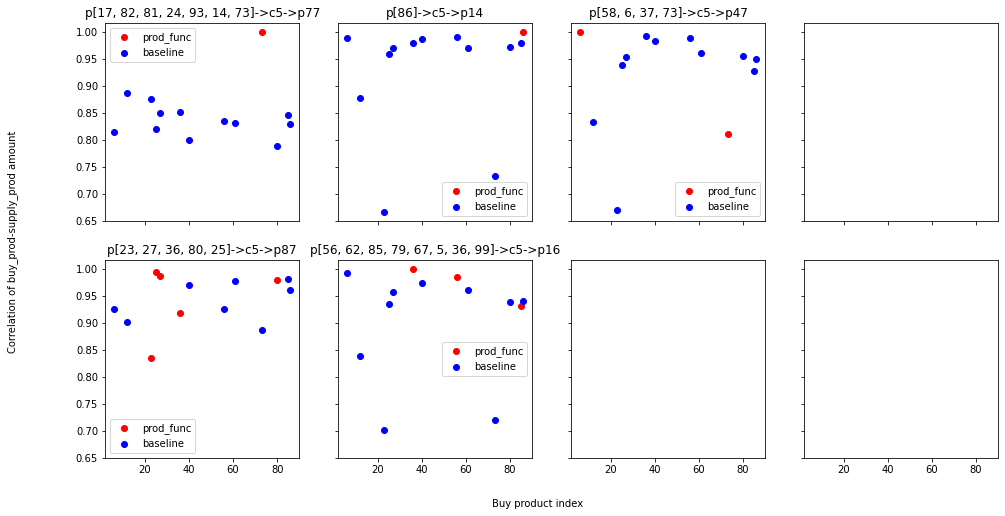

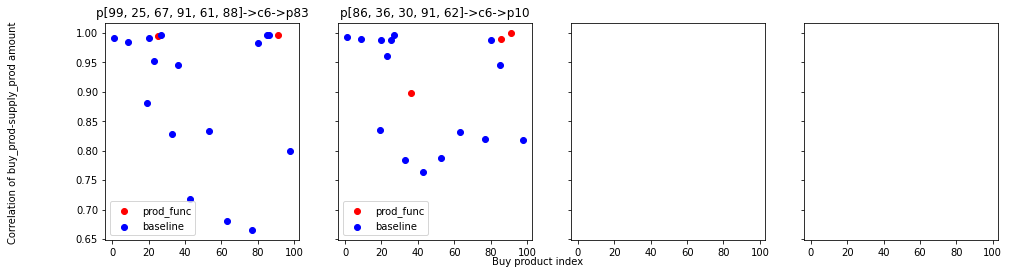

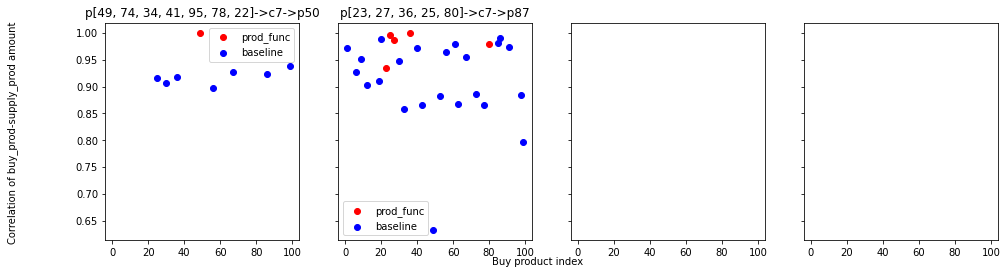

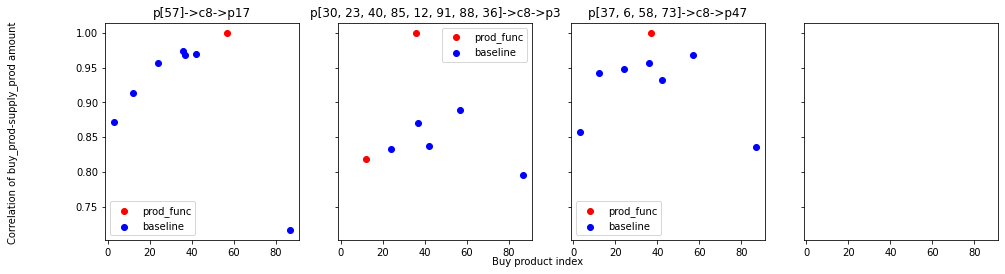

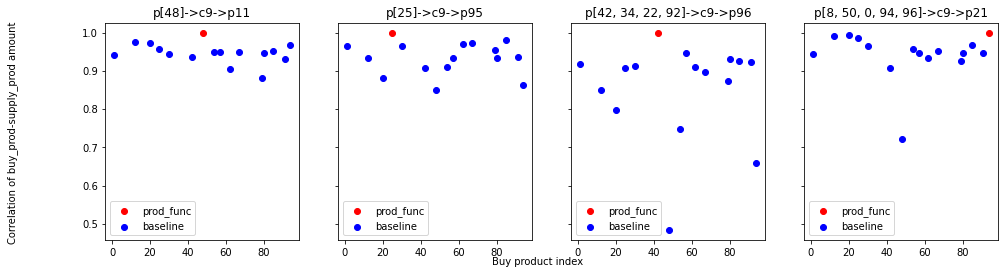

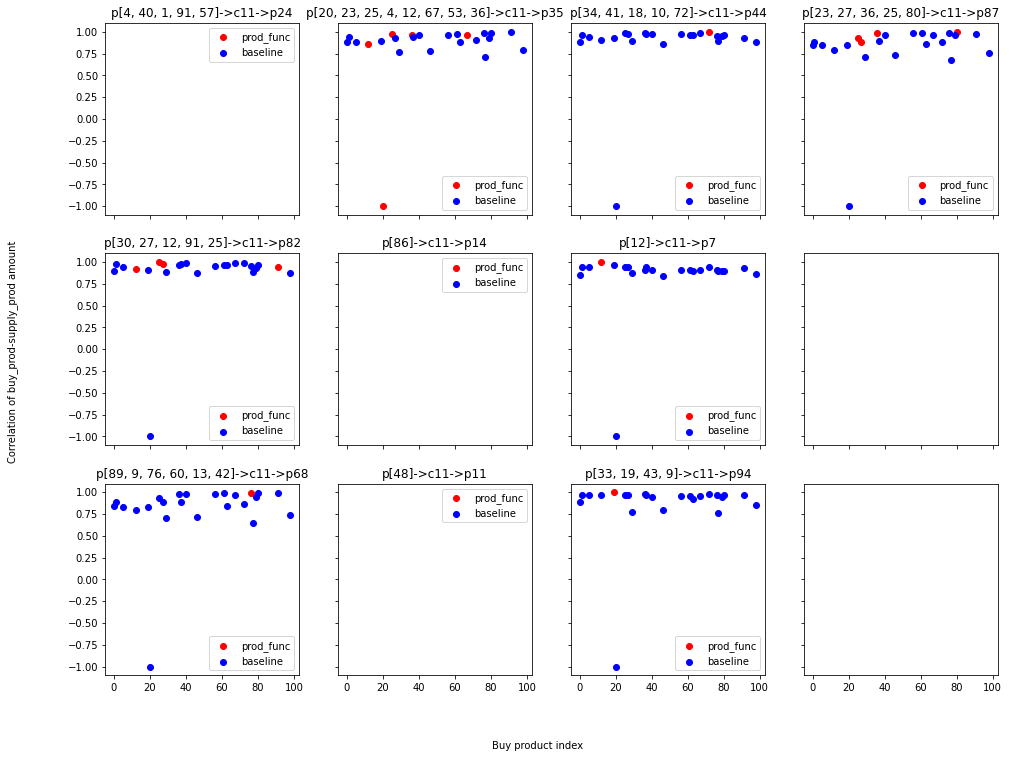

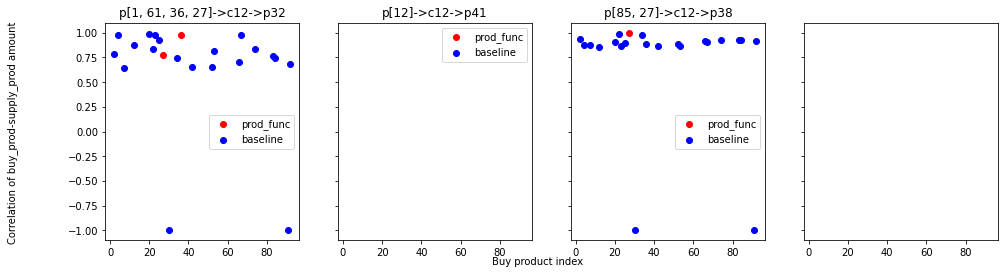

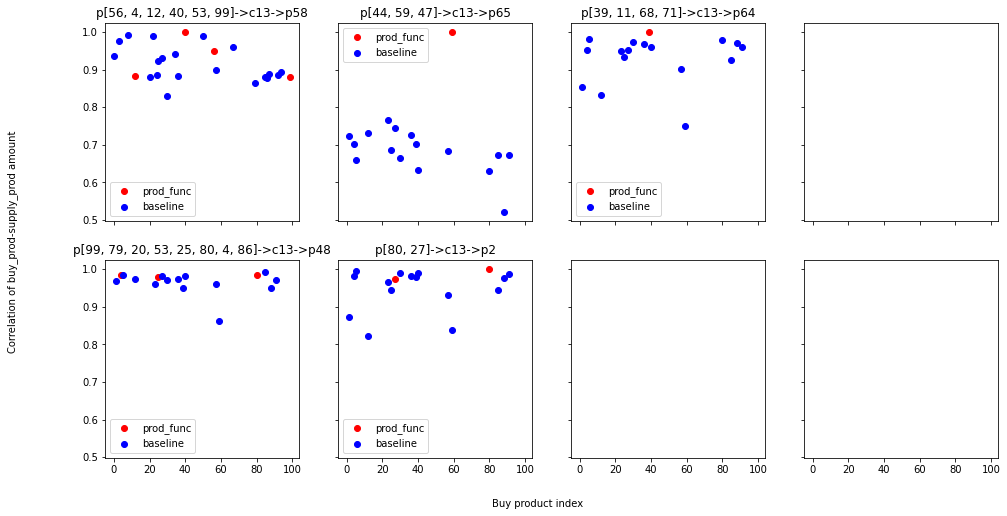

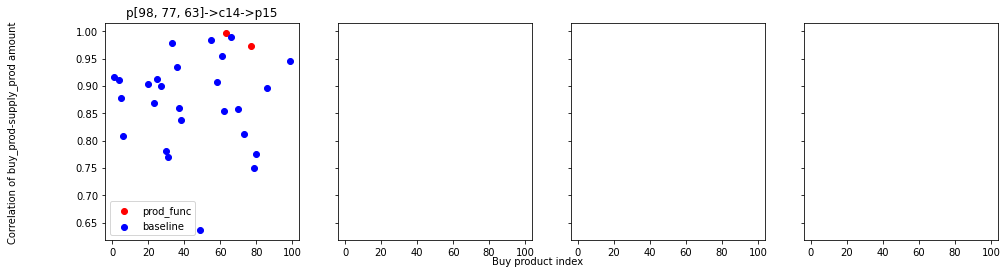

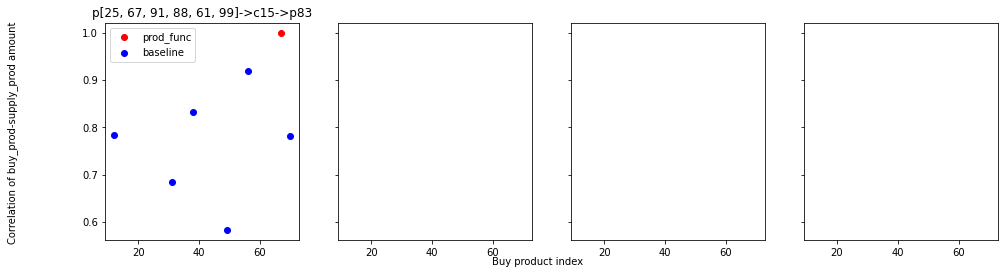

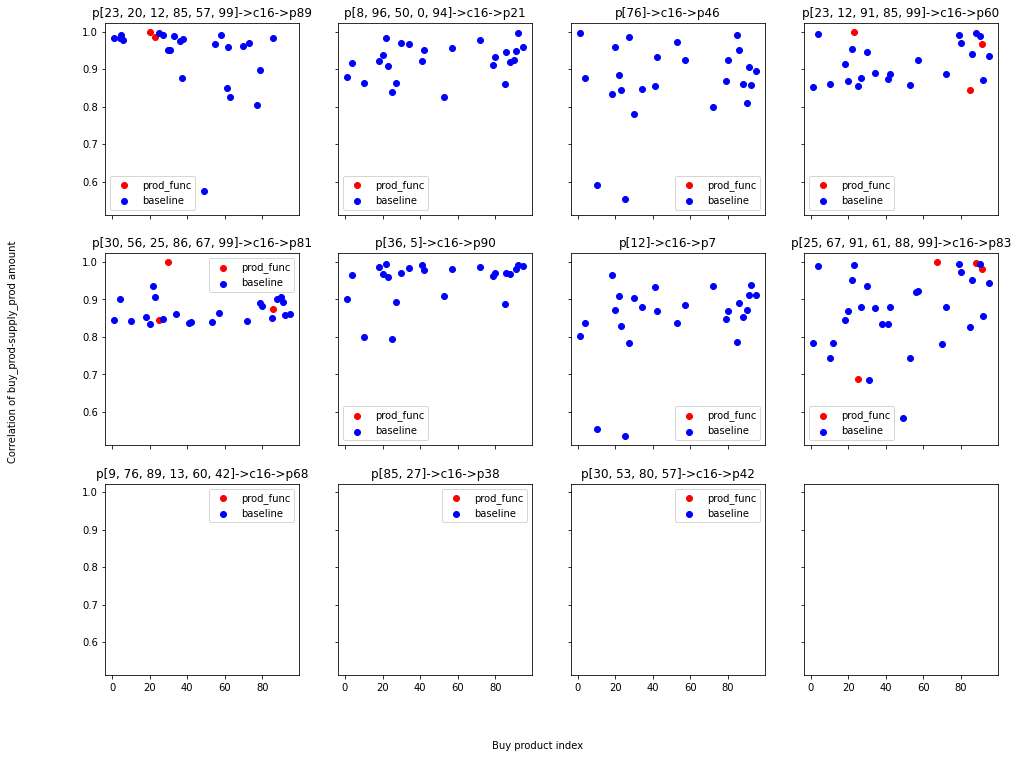

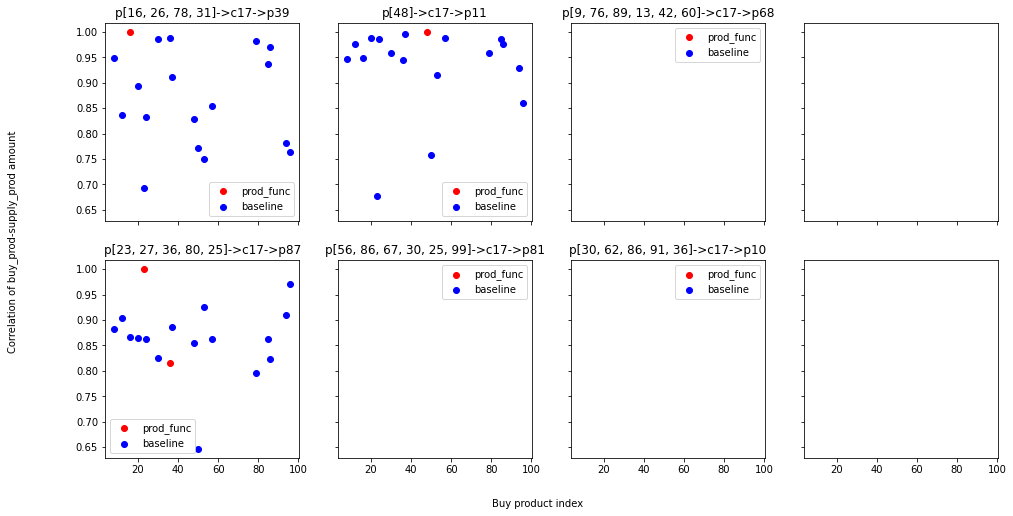

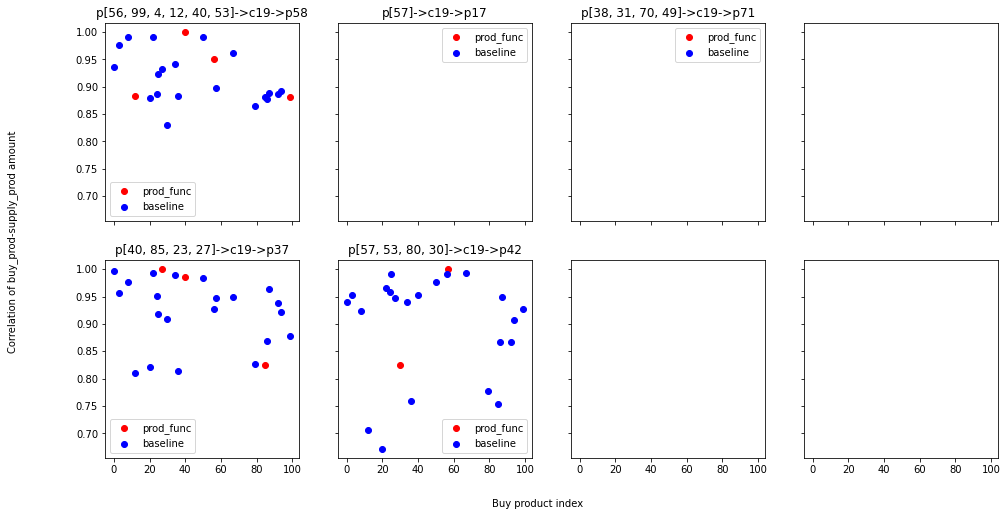

In [44]:
avg_p_list = []
for COMPANY in range(21):
    # Read in result as result_df for COMPANY
    result_df = pd.read_csv(f'./result/result{COMPANY}.csv') 
    result_df = result_df.fillna(-1)

    # Construct production function dataframe for COMPANY
    prod_df = df[df["company"]==COMPANY].reset_index(drop=True)
    avg_p = None
    if prod_df.shape[0]==0: 
        print(f"Plot company {COMPANY} has no linear production function")
    else:
        print(f"Plot company {COMPANY}: result shape {result_df.shape} and linear production functions shape {prod_df.shape}")
        avg_p = plot(result_df, prod_df, COMPANY)
    
    avg_p_list.append(avg_p)
info_df = pd.DataFrame.from_dict({'average percentage': avg_p_list})

In [45]:
info_df

,average percentage
0,0.722428
1,0.681857
2,0.859919
3,0.677797
4,1.000000
5,0.701326
6,0.778333
7,0.884058
8,0.800000
9,1.000000
